In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import Dataset
from pipeline import Pipeline
from visualizations import Visualizer
from sklearn.linear_model import Ridge, HuberRegressor
import sklearn.preprocessing
from sklearn.svm import LinearSVR, SVR
from sklearn.decomposition import PCA, KernelPCA
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
rmse = MeanSquaredError(square_root = True)
from scipy.linalg import LinAlgWarning
import sklearn.model_selection
import warnings
import mlflow
import argparse
from skopt import space, plots
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

class Args():
    def __init__(self):
        self.ticker = "btc"
args = Args()
args.ticker = "btc"
mlflow.set_experiment(args.ticker + "_17.3.2025-returns")

# Filter out LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)
#controling whether tensorflow does recognize GPU
tf.config.get_visible_devices("GPU")
np.random.seed(42)
tf.random.set_seed(42)

mlflow.sklearn.autolog(disable=True)
pipeline = Pipeline(crypto_tick = args.ticker, returns=True)
if args.ticker == "eth":
    pipeline.set_beginning(start_date = "2015-08-08")
else:
    pipeline.set_beginning(start_date = "2014-9-17")
    
pipeline.preprocess_dataset()
pipeline.data.drop(columns = [f'{args.ticker.upper()} / NVT, adjusted, free float,  90d MA',
                              f'{args.ticker.upper()} / NVT, adjusted, 90d MA',
                              f'{args.ticker.upper()} / NVT, adjusted, free float',
                              f'{args.ticker.upper()} / Fees, transaction, median, USD', 
                              f'{args.ticker.upper()} / Fees, total, USD',
                              f'{args.ticker.upper()} / Capitalization, market, free float, USD',
                              f'{args.ticker.upper()} / Capitalization, market, current supply, USD',
                              f'{args.ticker.upper()} / Capitalization, market, estimated supply, USD',
                              f'{args.ticker.upper()} / Difficulty, mean',
#                              f'{args.ticker.upper()} / Hash rate, mean, 30d',
                              f'{args.ticker.upper()} / Transactions, transfers, count',
                            f'{args.ticker.upper()} / Transactions, transfers, value, mean, USD'
                              ], inplace = True)

if args.ticker == "btc":
    pipeline.data.drop(columns = [f'{args.ticker.upper()} / Hash rate, mean, 30d'], inplace = True)

"""
['BTC / Addresses, active, count', 'BTC / NVT, adjusted, 90d MA',
       'BTC / NVT, adjusted', 'BTC / Flow, in, to exchanges, USD',
       'BTC / Flow, out, from exchanges, USD',
       'BTC / Fees, transaction, mean, USD', 'BTC / Miner revenue, USD',
       'BTC / Capitalization, realized, USD',
       'BTC / Volatility, daily returns, 30d',
       'BTC / Volatility, daily returns, 180d', 'BTC / Difficulty, last',
       'BTC / Hash rate, mean', 'BTC / Revenue, per hash unit, USD',
       'BTC / Supply, Miner, held by all mining entities, USD',
       'BTC / Block, size, mean, bytes', 'BTC / Block, weight, mean',
       'BTC / Issuance, continuous, percent, daily',
       'BTC / Network distribution factor', 'BTC / Transactions, count',
       'Google_btc_search', 'Wiki_btc_search', 'Close_^DJI', 'Close_^GSPC',
       'Close_GC=F', 'Close_^VIX', 'Close_^IXIC', 'Close_SMH', 'Close_VGT',
       'Close_XSD', 'Close_IYW', 'Close_FTEC', 'Close_IGV', 'Close_QQQ',
       'Google_crypto_search', 'Wiki_crypto_search', 'RGDP_US', 'RGDP_PC_US',
       'CPI_US', 'M2_US', 'USD_EUR_rate', 'BTC-USD']
"""
pipeline.data.drop(columns = ['BTC / Volatility, daily returns, 180d', 'BTC / Miner revenue, USD', 'BTC / Difficulty, last', 'BTC / Supply, Miner, held by all mining entities, USD',
                              'BTC / Block, size, mean, bytes', 'BTC / Block, weight, mean', 'BTC / Issuance, continuous, percent, daily',
       'BTC / Network distribution factor', 'Close_GC=F', 'Close_^IXIC', 'Close_VGT', 'Close_XSD', 'Close_IYW', 'Close_FTEC', 'Close_IGV',
       'RGDP_US', 'RGDP_PC_US', 'M2_US'], inplace = True)

pipeline.shift_target()
columns = [f"{args.ticker.upper()}-LR - 1 day", f"{args.ticker.upper()}-LR - 5 days", 
                   f"{args.ticker.upper()}-LR - 10 days", f"{args.ticker.upper()}-SVR - 1 day", 
                   f"{args.ticker.upper()}-SVR - 5 days", 
                   f"{args.ticker.upper()}-SVR - 10 days", f"{args.ticker.upper()}-LSTM - 1 day", 
                   f"{args.ticker.upper()}-LSTM - 5 days", f"{args.ticker.upper()}-LSTM - 10 days", 
                   "Naive forceast - 1 day", "Naive forceast - 5 days",
                   "Naive forceast - 10 days"]
rows = ["Full dimensionality", "95% retained variance",
                "98% retained variance", "99% retained variance"]
#presented in RMSE which is the optimized metric
results_train_averaged = pd.DataFrame(columns = columns, index = rows).fillna(0).astype(int)
columns = [f"{args.ticker.upper()}-LR - 1 day", f"{args.ticker.upper()}-LR - 5 days", 
                   f"{args.ticker.upper()}-LR - 10 days", 
                   f"{args.ticker.upper()}-SVR - 1 day", f"{args.ticker.upper()}-SVR - 5 days", 
                   f"{args.ticker.upper()}-SVR - 10 days", 
                   f"{args.ticker.upper()}-LSTM - 1 day", f"{args.ticker.upper()}-LSTM - 5 days", 
                   f"{args.ticker.upper()}-LSTM - 10 days", "Naive forceast - 1 day", "Naive forceast - 5 days",
                   "Naive forceast - 10 days"]
rows = ["Full dimensionality", "95% retained variance",
                "98% retained variance", "99% retained variance"]
#presented in RMSE which is the optimized metric
results_test = pd.DataFrame(columns = columns, index = rows).fillna(0).astype(int)


#Naive forecast
# Cap outliers on the train_target datasets
def cap_outliers(data, lower_percentile=2, upper_percentile=98):
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    return np.clip(data, lower_bound, upper_bound)


x,y = Pipeline.create_lstm_input(pipeline.data_1d_shift.copy(), pipeline.data_1d_shift.copy().iloc[:,-1], 3)
train_data_1, test_data_1, train_target_1, test_target_1 = Pipeline.split_train_test([x,y], pandas=False)
train_target_1 = cap_outliers(train_target_1)
x,y = Pipeline.create_lstm_input(pipeline.data_5d_shift.copy(), pipeline.data_5d_shift.copy().iloc[:,-1], 3)
train_data_5, test_data_5, train_target_5, test_target_5 = Pipeline.split_train_test([x,y], pandas=False)
train_target_5 = cap_outliers(train_target_5)
x,y = Pipeline.create_lstm_input(pipeline.data_10d_shift.copy(), pipeline.data_10d_shift.copy().iloc[:,-1], 3)
train_data_10, test_data_10, train_target_10, test_target_10 = Pipeline.split_train_test([x,y], pandas=False)
train_target_10 = cap_outliers(train_target_10)
results_train_averaged["Naive forceast - 1 day"] = rmse(train_target_1, np.zeros_like(train_target_1))
results_train_averaged["Naive forceast - 5 days"] = rmse(train_target_5, np.zeros_like(train_target_5))
results_train_averaged["Naive forceast - 10 days"] = rmse(train_target_10, np.zeros_like(train_target_10))
results_test["Naive forceast - 1 day"] = rmse(test_target_1, np.zeros_like(test_target_1))
results_test["Naive forceast - 5 days"] = rmse(test_target_5, np.zeros_like(test_target_5))
results_test["Naive forceast - 10 days"] = rmse(test_target_10, np.zeros_like(test_target_10))

print(rmse(train_target_1, np.zeros_like(train_target_1)))
print(rmse(train_target_5, np.zeros_like(train_target_5)))
print(rmse(train_target_10, np.zeros_like(train_target_10)))
print(rmse(test_target_1, np.zeros_like(test_target_1)))
print(rmse(test_target_5, np.zeros_like(test_target_5)))
print(rmse(test_target_10, np.zeros_like(test_target_10)))
#Linear Regression
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=1, random_state = 42, shuffle = True,
                    batch_size = 10,epochs=300, input_shape=(3, len(pipeline.data.columns)),
                    units = 30, dropout = 0.3,lr_initial = 0.01), dim_reducer = None, shape_change = ((-1, len(pipeline.data.columns)), (-1,3,len(pipeline.data.columns))))

LR_PARAMETERS = {"estimator__alpha": space.Real(0, 5, prior = 'uniform'),
              "estimator__tol":space.Real(1e-5, 10, prior = 'log-uniform'),
              "estimator__epsilon": space.Real(1, 10, prior = 'log-uniform')}

pipe.fit(train_data_1, train_target_1)

0.03427212138918002
0.080772682809824
0.11713347236122999
0.03329883810784264
0.07545537357869835
0.106233901567042


2025-03-18 14:55:29.727245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-18 14:55:29.729171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-18 14:55:29.730307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/300


2025-03-18 14:55:29.967000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2719]
	 [[{{node Placeholder/_11}}]]
2025-03-18 14:55:29.967214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2719]
	 [[{{node Placeholder/_11}}]]
2025-03-18 14:55:30.203130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

In [ ]:
pipeline.data.columns

Index(['BTC / Addresses, active, count', 'BTC / NVT, adjusted',
       'BTC / Flow, in, to exchanges, USD',
       'BTC / Flow, out, from exchanges, USD',
       'BTC / Fees, transaction, mean, USD',
       'BTC / Capitalization, realized, USD',
       'BTC / Volatility, daily returns, 30d', 'BTC / Hash rate, mean',
       'BTC / Revenue, per hash unit, USD', 'BTC / Transactions, count',
       'Google_btc_search', 'Wiki_btc_search', 'Close_^DJI', 'Close_^GSPC',
       'Close_^VIX', 'Close_SMH', 'Close_QQQ', 'Google_crypto_search',
       'Wiki_crypto_search', 'CPI_US', 'USD_EUR_rate', 'BTC-USD'],
      dtype='object')

2025-03-18 14:53:42.978320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [2719,3,22]
	 [[{{node Placeholder/_10}}]]
2025-03-18 14:53:42.978597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [2719,3,22]
	 [[{{node Placeholder/_10}}]]
2025-03-18 14:53:43.154754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2

17/28 [=================>............] - ETA: 0s 

2025-03-18 14:53:43.312479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-18 14:53:43.314032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-18 14:53:43.315139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step


2025-03-18 14:53:43.565674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [303,3,22]
	 [[{{node Placeholder/_10}}]]
2025-03-18 14:53:43.565856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [303,3,22]
	 [[{{node Placeholder/_10}}]]


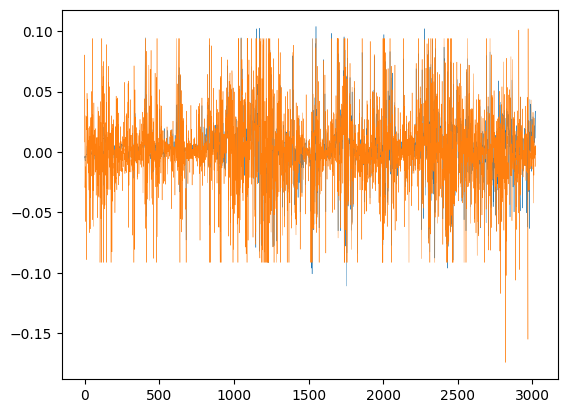

In [ ]:
plt.plot(np.concatenate([pipe.predict(train_data_1), pipe.predict(test_data_1)]), linewidth=0.3)
plt.plot(np.concatenate([train_target_1,test_target_1]), linewidth=0.3)

28/28 [==============================] - 0s 3ms/step


2025-03-18 14:53:43.773894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [2719,3,22]
	 [[{{node Placeholder/_10}}]]
2025-03-18 14:53:43.774069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [2719,3,22]
	 [[{{node Placeholder/_10}}]]


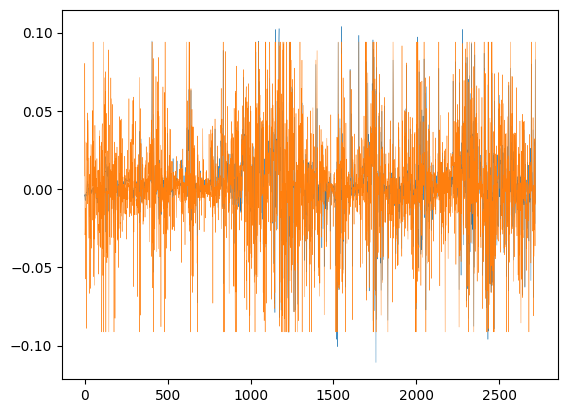

In [ ]:
plt.plot(np.concatenate([pipe.predict(train_data_1)]), linewidth=0.3)
plt.plot(np.concatenate([train_target_1]), linewidth=0.3)

4/4 [==============================] - 0s 5ms/step


2025-03-18 14:53:44.041765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [303,3,22]
	 [[{{node Placeholder/_10}}]]
2025-03-18 14:53:44.042040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [303,3,22]
	 [[{{node Placeholder/_10}}]]


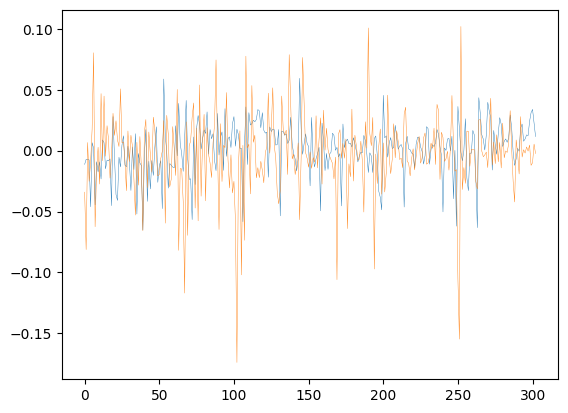

In [ ]:
plt.plot(np.concatenate([pipe.predict(test_data_1)]), linewidth=0.3)
plt.plot(np.concatenate([test_target_1]), linewidth=0.3)

In [ ]:
rmse(train_target_1, pipe.predict(train_data_1))

 1/28 [>.............................] - ETA: 0s

2025-03-18 14:53:44.187147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [2719,3,22]
	 [[{{node Placeholder/_10}}]]
2025-03-18 14:53:44.187323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [2719,3,22]
	 [[{{node Placeholder/_10}}]]


28/28 [==============================] - 0s 3ms/step


0.02183967694113008

In [ ]:
rmse(test_target_1, pipe.predict(test_data_1))

4/4 [==============================] - 0s 4ms/step


2025-03-18 14:53:44.330842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [303,3,22]
	 [[{{node Placeholder/_10}}]]
2025-03-18 14:53:44.331013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [303,3,22]
	 [[{{node Placeholder/_10}}]]


0.03980508271010839